### Background information

In this notebook I am doing EDA and data cleaning for extracted health dataset from MIMIC-IV dataset.

### Aggregating the Time-Series Data

For the Exploratory Data Analysis (EDA), I have opted to aggregate the time series data from the last 8 hours based on their mean. The rationale behind this decision is as follows:

1. Sun et al. (2021) argue that the most recent physiological measurements are often the most relevant for predicting outcomes in ICU settings. Aggregating data from the last 8 hours provides a summary of the patient's current health status, which is crucial for predicting immediate risks like mortality.

2. Since the purpose of EDA for this dataset is to perform dimensionality reduction or feature selection in Assignment 4, it is necessary to convert the dataset from a time-series format into a more suitable format. BMC Medical Informatics and Decision Making (2021) stated that "using summary statistics such as the mean, median, and standard deviation reduces the complexity and noise of high-dimensional time series data, making it more suitable for predictive modeling".

### References:
- Ghassemi, M., Celi, L. A., Stone, D. J. (2015). "State-of-the-Art Review: The Data Revolution in Critical Care." Critical Care, 19(1), 118. [Link to paper](https://doi.org/10.1186/s13054-015-0801-4)
- Sun, J., et al. (2021). "Deep Multi-Modal Intermediate Fusion of Clinical Record and Time Series Data in Mortality Prediction." Frontiers in Medicine. [Link to paper](https://www.frontiersin.org/articles/10.3389/fmed.2021.645500/full)
- BMC Medical Informatics and Decision Making. (2021). "An Evaluation of Time Series Summary Statistics as Features for Clinical Prediction Tasks." [Link to paper](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-021-01454-1)


# Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy, norm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import chi2
pd.set_option('display.max_columns', None)

mimic = pd.read_csv("health_dataset.csv")
data = mimic.copy()
display(data.head())
print(f"This dataset contains {data.shape[0]} rows and {data.shape[1]} columns.")

SUBJECT_ID   HADM_ID  ICUSTAY_ID  AGE GENDER ETHNICITY  HEART_RATE  \
0    18868417  21481340    36475723   77      M     OTHER      74.250   
1    17030222  22455492    30262362   85      F     WHITE      77.625   
2    15664318  21206710    38572720   44      F     OTHER     103.750   
3    13970700  20870207    38790488   91      F     WHITE      69.625   
4    17035582  20664949    37164270   63      M     WHITE      81.625   

    DIASBP   SYSTBP  MABP  TEMPERATURE  O2SAT  RESP_RATE  ALBUMIN        BUN  \
0      NaN      NaN   NaN      98.1125    NaN     18.375      NaN  33.375000   
1   24.125   40.875   NaN      97.3875    NaN     12.250      NaN  25.400000   
2  120.250  130.250   NaN      98.5125   97.0     20.625      2.6  22.250000   
3   52.625  133.500   NaN      97.3625    NaN     17.750      NaN  16.833333   
4   42.875   97.000   NaN      98.2750    NaN     25.625      NaN  29.500000   

   BILIRUBIN   LACTATE  BICARBONATE  BAND_NEUTROPHIL  CHLORIDE  CREATININE  \
0        NaN  1.300000       27.875              NaN  105.0000    1.537500   
1        NaN  1.483333       26.000              NaN  106.2000    0.740000   
2       0.25  1.610000       26.500              NaN  102.6250    3.937500   
3        NaN       NaN       25.000              NaN  101.5625    0.641667   
4       0.50  2.450000       23.625              NaN  105.3750    0.900000   

      GLUCOSE  HEMOGLOBIN  HEMATOCRIT  PLATELET_COUNT  POTASSIUM        PTT  \
0  105.250000    15.47500    49.75000        169.0000      4.000  75.287500   
1  120.600000    12.27500    37.45000        311.2500      3.940  43.066667   
2   98.250000     7.73750    26.21250        496.7500      4.575  32.000000   
3   94.083333    11.03125    30.93125        212.8125      3.875  36.700000   
4  129.250000    11.18750    30.02500        218.9375      4.325  31.171429   

    SODIUM      WBC  HOSPITAL_EXPIRE_FLAG  
0  141.875   9.5625                     0  
1  142.600   9.1500                     1  
2  139.500  17.9750                     0  
3  133.500   7.7125                     0  
4  140.125  11.3000                     0

This dataset contains 22565 rows and 30 columns.


To aid our analysis, I am going to split the dataset into 2 separate dataframe, first one is for patients who did not expire 'data1', and the other for patients who expired 'data0'.

In [2]:
# Split the dataset
data0 = data[data['HOSPITAL_EXPIRE_FLAG'] == 0]
data1 = data[data['HOSPITAL_EXPIRE_FLAG'] == 1]

# Display the first few rows of each DataFrame to verify
print("Data0 (HOSPITAL_EXPIRE_FLAG == 0):")
display(data0.head())

print("Data1 (HOSPITAL_EXPIRE_FLAG == 1):")
display(data1.head())

# Print the shapes to confirm the number of rows in each DataFrame
print(f"Data0 contains {data0.shape[0]} rows and {data0.shape[1]} columns.")
print(f"Data1 contains {data1.shape[0]} rows and {data1.shape[1]} columns.")

Data0 (HOSPITAL_EXPIRE_FLAG == 0):


SUBJECT_ID   HADM_ID  ICUSTAY_ID  AGE GENDER ETHNICITY  HEART_RATE  \
0    18868417  21481340    36475723   77      M     OTHER      74.250   
2    15664318  21206710    38572720   44      F     OTHER     103.750   
3    13970700  20870207    38790488   91      F     WHITE      69.625   
4    17035582  20664949    37164270   63      M     WHITE      81.625   
5    10457824  25280974    32230380   80      M   UNKNOWN     109.500   

    DIASBP  SYSTBP  MABP  TEMPERATURE  O2SAT  RESP_RATE   ALBUMIN        BUN  \
0      NaN     NaN   NaN      98.1125    NaN     18.375       NaN  33.375000   
2  120.250  130.25   NaN      98.5125   97.0     20.625  2.600000  22.250000   
3   52.625  133.50   NaN      97.3625    NaN     17.750       NaN  16.833333   
4   42.875   97.00   NaN      98.2750    NaN     25.625       NaN  29.500000   
5      NaN     NaN   NaN      98.2875    NaN     28.375  2.166667   7.000000   

   BILIRUBIN  LACTATE  BICARBONATE  BAND_NEUTROPHIL  CHLORIDE  CREATININE  \
0        NaN     1.30       27.875              NaN  105.0000    1.537500   
2      0.250     1.61       26.500              NaN  102.6250    3.937500   
3        NaN      NaN       25.000              NaN  101.5625    0.641667   
4      0.500     2.45       23.625              NaN  105.3750    0.900000   
5      0.925     1.20       28.125              6.2   99.2500    0.550000   

      GLUCOSE  HEMOGLOBIN  HEMATOCRIT  PLATELET_COUNT  POTASSIUM        PTT  \
0  105.250000    15.47500    49.75000        169.0000     4.0000  75.287500   
2   98.250000     7.73750    26.21250        496.7500     4.5750  32.000000   
3   94.083333    11.03125    30.93125        212.8125     3.8750  36.700000   
4  129.250000    11.18750    30.02500        218.9375     4.3250  31.171429   
5  164.375000     8.18750    24.77500        588.0000     4.0125  63.393750   

    SODIUM      WBC  HOSPITAL_EXPIRE_FLAG  
0  141.875   9.5625                     0  
2  139.500  17.9750                     0  
3  133.500   7.7125                     0  
4  140.125  11.3000                     0  
5  138.750  19.0250                     0

Data1 (HOSPITAL_EXPIRE_FLAG == 1):


SUBJECT_ID   HADM_ID  ICUSTAY_ID  AGE GENDER ETHNICITY  HEART_RATE  \
1     17030222  22455492    30262362   85      F     WHITE   77.625000   
11    14405232  24340879    31011196   55      F   UNKNOWN   93.750000   
15    10641937  22804676    33298911   63      M     WHITE   99.979167   
26    12026338  28548230    32163537   68      F     WHITE   89.750000   
29    11439927  23639754    37817300   89      F     WHITE   80.166667   

       DIASBP     SYSTBP  MABP  TEMPERATURE  O2SAT  RESP_RATE   ALBUMIN  \
1   24.125000  40.875000   NaN    97.387500    NaN    12.2500       NaN   
11        NaN        NaN   NaN    97.522917    NaN    23.7500  3.666667   
15  50.833333  72.666667   NaN    99.025000    NaN    22.8750  2.712500   
26  62.000000  96.250000   NaN    99.775000   99.0    17.1250  2.600000   
29  19.000000  34.500000   NaN    98.250000   74.0    17.4375  3.350000   

          BUN  BILIRUBIN   LACTATE  BICARBONATE  BAND_NEUTROPHIL    CHLORIDE  \
1   25.400000        NaN  1.483333    26.000000              NaN  106.200000   
11  58.375000    35.6000  2.700000    20.125000            0.000  107.375000   
15  91.250000     8.4625  2.248958    16.500000            0.875  108.875000   
26  20.333333     0.4000  2.585000    16.604167              NaN  107.958333   
29  84.125000     0.5000  2.800000    30.875000            3.000   90.625000   

    CREATININE     GLUCOSE  HEMOGLOBIN  HEMATOCRIT  PLATELET_COUNT  POTASSIUM  \
1     0.740000  120.600000    12.27500   37.450000      311.250000   3.940000   
11    2.150000  176.125000     7.90625   23.691667       81.687500   3.875000   
15    2.362500  124.250000     7.76250   22.987500       23.187500   4.650000   
26    1.552083  118.104167    10.34375   31.327083       95.770833   4.966667   
29    3.125000  259.500000     9.91250   32.575000      150.625000   3.650000   

          PTT      SODIUM       WBC  HOSPITAL_EXPIRE_FLAG  
1   43.066667  142.600000   9.15000                     1  
11  50.325000  142.500000  20.06875                     1  
15  43.787500  139.250000   3.99375                     1  
26  43.018750  137.541667   4.41875                     1  
29  54.362500  136.500000   9.67500                     1

Data0 contains 19286 rows and 30 columns.
Data1 contains 3279 rows and 30 columns.


### Checking for missing values

I am going to check missing values for the original 'data', 'data0', and 'data1'.

In [3]:
def Missing_Values(data):
    var_name = []
    data_type = []
    total_value = []
    total_missing_value = []
    missing_value_pct = []
    unique_value = []
    total_unique_value = []

    
    for col in data.columns:
        var_name.append(col)
        data_type.append(data[col].dtype)
        total_value.append(data[col].shape[0])
        total_missing_value.append(data[col].isnull().sum())
        missing_value_pct.append(round(data[col].isnull().sum()/data[col].shape[0],3))
        unique_value.append(data[col].unique())
        total_unique_value.append(len(data[col].unique()))
        
    missing_data=pd.DataFrame({"Variable":var_name,\
                               "Data_Type":data_type,\
                               "No_Total_Value":total_value,\
                               "No_Total_Missing_Value":total_missing_value,\
                               "Proportion_Missing_Value":missing_value_pct,\
                               "Unique_Value":unique_value,\
                               "Total_Unique_Value":total_unique_value
                              })
    
    missing_data = missing_data.set_index("Variable")
    return missing_data
 

In [4]:
# Checking missing values for the entire dataset
Missing_Values(data)

Data_Type  No_Total_Value  No_Total_Missing_Value  \
Variable                                                                 
SUBJECT_ID               int64           22565                       0   
HADM_ID                  int64           22565                       0   
ICUSTAY_ID               int64           22565                       0   
AGE                      int64           22565                       0   
GENDER                  object           22565                       0   
ETHNICITY               object           22565                       0   
HEART_RATE             float64           22565                       1   
DIASBP                 float64           22565                   10265   
SYSTBP                 float64           22565                   10272   
MABP                   float64           22565                   19878   
TEMPERATURE            float64           22565                      94   
O2SAT                  float64           22565                   13816   
RESP_RATE              float64           22565                       1   
ALBUMIN                float64           22565                    7511   
BUN                    float64           22565                       0   
BILIRUBIN              float64           22565                    5788   
LACTATE                float64           22565                    3918   
BICARBONATE            float64           22565                       0   
BAND_NEUTROPHIL        float64           22565                   16661   
CHLORIDE               float64           22565                       0   
CREATININE             float64           22565                       4   
GLUCOSE                float64           22565                       0   
HEMOGLOBIN             float64           22565                       0   
HEMATOCRIT             float64           22565                       0   
PLATELET_COUNT         float64           22565                       1   
POTASSIUM              float64           22565                       0   
PTT                    float64           22565                     652   
SODIUM                 float64           22565                       0   
WBC                    float64           22565                       0   
HOSPITAL_EXPIRE_FLAG     int64           22565                       0   

                      Proportion_Missing_Value  \
Variable                                         
SUBJECT_ID                               0.000   
HADM_ID                                  0.000   
ICUSTAY_ID                               0.000   
AGE                                      0.000   
GENDER                                   0.000   
ETHNICITY                                0.000   
HEART_RATE                               0.000   
DIASBP                                   0.455   
SYSTBP                                   0.455   
MABP                                     0.881   
TEMPERATURE                              0.004   
O2SAT                                    0.612   
RESP_RATE                                0.000   
ALBUMIN                                  0.333   
BUN                                      0.000   
BILIRUBIN                                0.257   
LACTATE                                  0.174   
BICARBONATE                              0.000   
BAND_NEUTROPHIL                          0.738   
CHLORIDE                                 0.000   
CREATININE                               0.000   
GLUCOSE                                  0.000   
HEMOGLOBIN                               0.000   
HEMATOCRIT                               0.000   
PLATELET_COUNT                           0.000   
POTASSIUM                                0.000   
PTT                                      0.029   
SODIUM                                   0.000   
WBC                                      0.000   
HOSPITAL_EXPIRE_FLAG                     0.000   

                                                   

In [5]:
# Checking missing values for patients who expired
Missing_Values(data0)

Data_Type  No_Total_Value  No_Total_Missing_Value  \
Variable                                                                 
SUBJECT_ID               int64           19286                       0   
HADM_ID                  int64           19286                       0   
ICUSTAY_ID               int64           19286                       0   
AGE                      int64           19286                       0   
GENDER                  object           19286                       0   
ETHNICITY               object           19286                       0   
HEART_RATE             float64           19286                       1   
DIASBP                 float64           19286                    8997   
SYSTBP                 float64           19286                    9003   
MABP                   float64           19286                   17243   
TEMPERATURE            float64           19286                      32   
O2SAT                  float64           19286                   12231   
RESP_RATE              float64           19286                       1   
ALBUMIN                float64           19286                    6898   
BUN                    float64           19286                       0   
BILIRUBIN              float64           19286                    5439   
LACTATE                float64           19286                    3748   
BICARBONATE            float64           19286                       0   
BAND_NEUTROPHIL        float64           19286                   14944   
CHLORIDE               float64           19286                       0   
CREATININE             float64           19286                       1   
GLUCOSE                float64           19286                       0   
HEMOGLOBIN             float64           19286                       0   
HEMATOCRIT             float64           19286                       0   
PLATELET_COUNT         float64           19286                       1   
POTASSIUM              float64           19286                       0   
PTT                    float64           19286                     612   
SODIUM                 float64           19286                       0   
WBC                    float64           19286                       0   
HOSPITAL_EXPIRE_FLAG     int64           19286                       0   

                      Proportion_Missing_Value  \
Variable                                         
SUBJECT_ID                               0.000   
HADM_ID                                  0.000   
ICUSTAY_ID                               0.000   
AGE                                      0.000   
GENDER                                   0.000   
ETHNICITY                                0.000   
HEART_RATE                               0.000   
DIASBP                                   0.467   
SYSTBP                                   0.467   
MABP                                     0.894   
TEMPERATURE                              0.002   
O2SAT                                    0.634   
RESP_RATE                                0.000   
ALBUMIN                                  0.358   
BUN                                      0.000   
BILIRUBIN                                0.282   
LACTATE                                  0.194   
BICARBONATE                              0.000   
BAND_NEUTROPHIL                          0.775   
CHLORIDE                                 0.000   
CREATININE                               0.000   
GLUCOSE                                  0.000   
HEMOGLOBIN                               0.000   
HEMATOCRIT                               0.000   
PLATELET_COUNT                           0.000   
POTASSIUM                                0.000   
PTT                                      0.032   
SODIUM                                   0.000   
WBC                                      0.000   
HOSPITAL_EXPIRE_FLAG                     0.000   

                                                   

In [6]:
# Checking missing values for patients who survived
Missing_Values(data1)

Data_Type  No_Total_Value  No_Total_Missing_Value  \
Variable                                                                 
SUBJECT_ID               int64            3279                       0   
HADM_ID                  int64            3279                       0   
ICUSTAY_ID               int64            3279                       0   
AGE                      int64            3279                       0   
GENDER                  object            3279                       0   
ETHNICITY               object            3279                       0   
HEART_RATE             float64            3279                       0   
DIASBP                 float64            3279                    1268   
SYSTBP                 float64            3279                    1269   
MABP                   float64            3279                    2635   
TEMPERATURE            float64            3279                      62   
O2SAT                  float64            3279                    1585   
RESP_RATE              float64            3279                       0   
ALBUMIN                float64            3279                     613   
BUN                    float64            3279                       0   
BILIRUBIN              float64            3279                     349   
LACTATE                float64            3279                     170   
BICARBONATE            float64            3279                       0   
BAND_NEUTROPHIL        float64            3279                    1717   
CHLORIDE               float64            3279                       0   
CREATININE             float64            3279                       3   
GLUCOSE                float64            3279                       0   
HEMOGLOBIN             float64            3279                       0   
HEMATOCRIT             float64            3279                       0   
PLATELET_COUNT         float64            3279                       0   
POTASSIUM              float64            3279                       0   
PTT                    float64            3279                      40   
SODIUM                 float64            3279                       0   
WBC                    float64            3279                       0   
HOSPITAL_EXPIRE_FLAG     int64            3279                       0   

                      Proportion_Missing_Value  \
Variable                                         
SUBJECT_ID                               0.000   
HADM_ID                                  0.000   
ICUSTAY_ID                               0.000   
AGE                                      0.000   
GENDER                                   0.000   
ETHNICITY                                0.000   
HEART_RATE                               0.000   
DIASBP                                   0.387   
SYSTBP                                   0.387   
MABP                                     0.804   
TEMPERATURE                              0.019   
O2SAT                                    0.483   
RESP_RATE                                0.000   
ALBUMIN                                  0.187   
BUN                                      0.000   
BILIRUBIN                                0.106   
LACTATE                                  0.052   
BICARBONATE                              0.000   
BAND_NEUTROPHIL                          0.524   
CHLORIDE                                 0.000   
CREATININE                               0.001   
GLUCOSE                                  0.000   
HEMOGLOBIN                               0.000   
HEMATOCRIT                               0.000   
PLATELET_COUNT                           0.000   
POTASSIUM                                0.000   
PTT                                      0.012   
SODIUM                                   0.000   
WBC                                      0.000   
HOSPITAL_EXPIRE_FLAG                     0.000   

                                                   

To aid with our EDA, the information about number of missing values for the whole dataset and per class is stored in the Excel file EDA -- **'Summary of Data Extraction Results.xlsx'**

### Dropping unused columns

I decide to drop SUBJECT_ID, HADM_ID, ICUSTAY_ID from the dataset as they contain unique value for each patient.

In [7]:
# Drop specified columns from the data DataFrame
data = data.drop(columns=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'])

# Display the first few rows of the modified data DataFrame
display(data.head())

# Print the shape of the modified data DataFrame
print(f"This dataset contains {data.shape[0]} rows and {data.shape[1]} columns.")


AGE GENDER ETHNICITY  HEART_RATE   DIASBP   SYSTBP  MABP  TEMPERATURE  \
0   77      M     OTHER      74.250      NaN      NaN   NaN      98.1125   
1   85      F     WHITE      77.625   24.125   40.875   NaN      97.3875   
2   44      F     OTHER     103.750  120.250  130.250   NaN      98.5125   
3   91      F     WHITE      69.625   52.625  133.500   NaN      97.3625   
4   63      M     WHITE      81.625   42.875   97.000   NaN      98.2750   

   O2SAT  RESP_RATE  ALBUMIN        BUN  BILIRUBIN   LACTATE  BICARBONATE  \
0    NaN     18.375      NaN  33.375000        NaN  1.300000       27.875   
1    NaN     12.250      NaN  25.400000        NaN  1.483333       26.000   
2   97.0     20.625      2.6  22.250000       0.25  1.610000       26.500   
3    NaN     17.750      NaN  16.833333        NaN       NaN       25.000   
4    NaN     25.625      NaN  29.500000       0.50  2.450000       23.625   

   BAND_NEUTROPHIL  CHLORIDE  CREATININE     GLUCOSE  HEMOGLOBIN  HEMATOCRIT  \
0              NaN  105.0000    1.537500  105.250000    15.47500    49.75000   
1              NaN  106.2000    0.740000  120.600000    12.27500    37.45000   
2              NaN  102.6250    3.937500   98.250000     7.73750    26.21250   
3              NaN  101.5625    0.641667   94.083333    11.03125    30.93125   
4              NaN  105.3750    0.900000  129.250000    11.18750    30.02500   

   PLATELET_COUNT  POTASSIUM        PTT   SODIUM      WBC  \
0        169.0000      4.000  75.287500  141.875   9.5625   
1        311.2500      3.940  43.066667  142.600   9.1500   
2        496.7500      4.575  32.000000  139.500  17.9750   
3        212.8125      3.875  36.700000  133.500   7.7125   
4        218.9375      4.325  31.171429  140.125  11.3000   

   HOSPITAL_EXPIRE_FLAG  
0                     0  
1                     1  
2                     0  
3                     0  
4                     0

This dataset contains 22565 rows and 27 columns.


## Target Feature

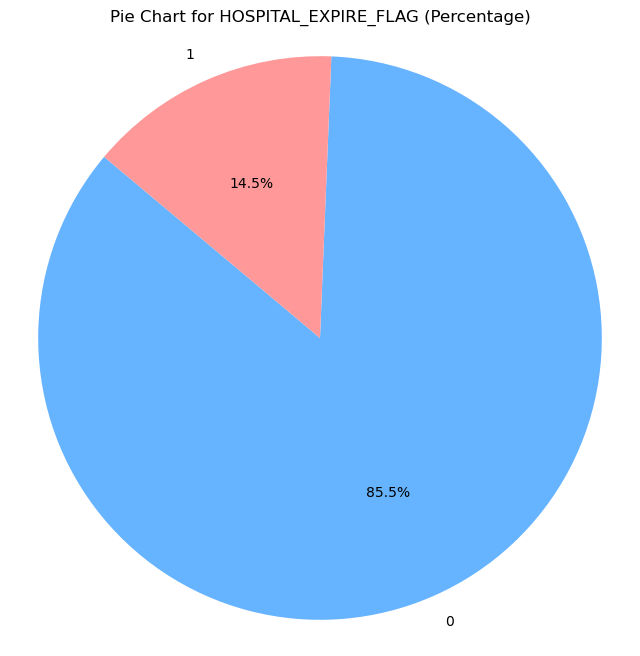

In [8]:
target = ['HOSPITAL_EXPIRE_FLAG']

target_counts = data[target[0]].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', colors=['#66b3ff','#ff9999'], startangle=140)
plt.title(f'Pie Chart for {target[0]} (Percentage)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

'HOSPITAL_EXPIRE_FLAG' indicates whether the patient died during the hospital stay (0 = did not expire, 1 = expired). The pie chart shows a heavily imbalanced target, with the value '0' comprising 86% of the total observations.

## Categorical Features

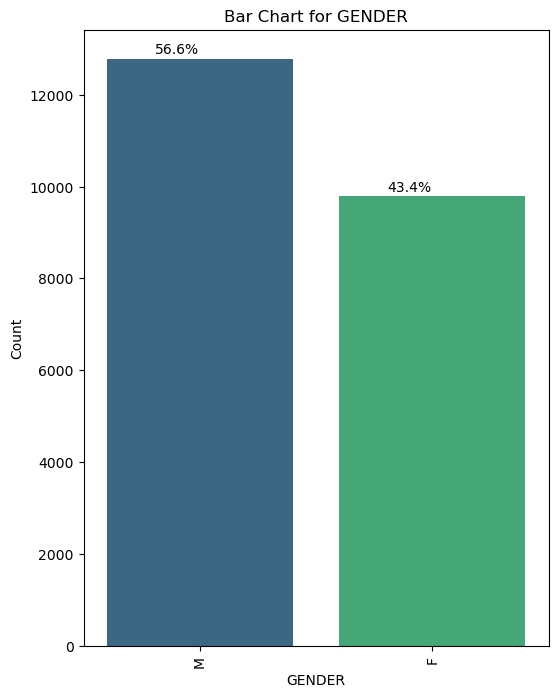

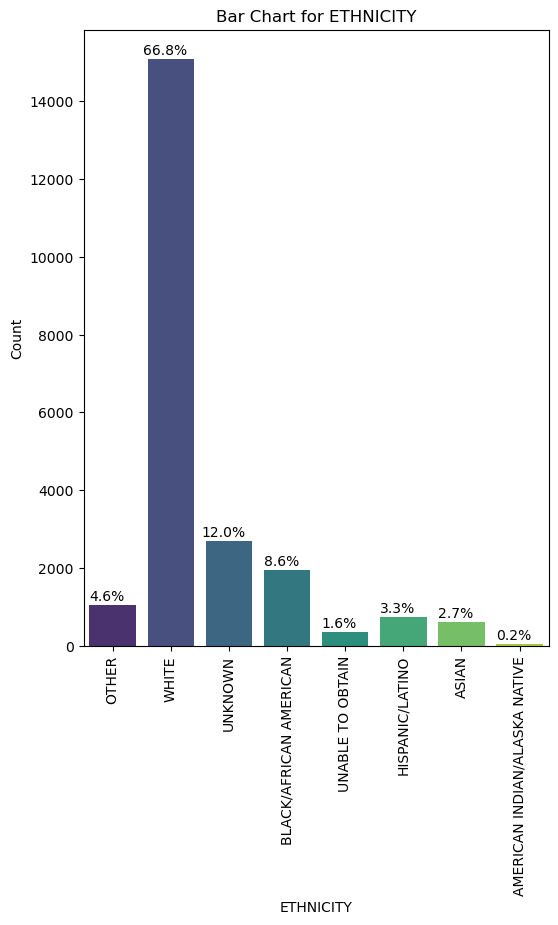

In [9]:
cat_cols = ['GENDER', 'ETHNICITY']
            
# Create bar charts with percentages
for col in cat_cols:
    plt.figure(figsize=(6, 8))
    ax = sns.countplot(data=data, x=col, palette='viridis')
    total = len(data[col])
    for p in ax.patches:
        frequency = p.get_height()
        percentage = f'{100 * frequency / total:.1f}%'
        x = p.get_x() + p.get_width() / 2 - 0.1
        y = p.get_height() + 0.005 * total
        ax.annotate(f'{percentage}', (x, y), size=10, ha='center')
    plt.title(f'Bar Chart for {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.show()

There is no missing values for 'GENDER' and 'ETHNICITY' features. There are only two genders in this dataset, with males making up 56.6% of all observations. For ethnicity, 'WHITE' dominates other ethnicities, making up 67% of all observations.

## Numerical Features

### Checking for Valid Range

I obtain the features description and valid range for each numerical features from the [paper](https://www.mdpi.com/2075-4426/11/9/934) provided from this assignment, the valid range are as follows:

In [10]:
num_cols_information = [
    {"Feature": "AGE", "Description": "The age of the patient.", "MIN": 0, "MAX": 91, "UNIT": "years"},
    {"Feature": "HEART_RATE", "Description": "Heart Rate: The average heart rate of the patient.", "MIN": 0, "MAX": 350, "UNIT": "bpm"},
    {"Feature": "DIASBP", "Description": "Diastolic Blood Pressure (diasbp): The average diastolic blood pressure of the patient.", "MIN": 0, "MAX": 375, "UNIT": "mmHg"},
    {"Feature": "SYSTBP", "Description": "Systolic Blood Pressure (systbp): The average systolic blood pressure of the patient.", "MIN": 0, "MAX": 375, "UNIT": "mmHg"},
    {"Feature": "MABP", "Description": "Mean Blood Pressure (meanbp): The average mean blood pressure of the patient.", "MIN": 14, "MAX": 330, "UNIT": "mmHg"},
    {"Feature": "TEMPERATURE", "Description": "Temperature: The average body temperature of the patient.", "MIN": 78.8, "MAX": 113, "UNIT": "°F"},
    {"Feature": "O2SAT", "Description": "Oxygen Saturation (o2sat): The average oxygen saturation of the patient.", "MIN": 0, "MAX": 100, "UNIT": "%"},
    {"Feature": "RESP_RATE", "Description": "Respiratory Rate (resp_rate): The average respiratory rate of the patient.", "MIN": 0, "MAX": 300, "UNIT": "breaths per minute"},
    {"Feature": "ALBUMIN", "Description": "Albumin: The average albumin level in the blood.", "MIN": 0.6, "MAX": 6, "UNIT": "g/dL"},
    {"Feature": "BUN", "Description": "Blood Urea Nitrogen (bun): The average blood urea nitrogen level.", "MIN": 0, "MAX": 250, "UNIT": "mg/dL"},
    {"Feature": "BILIRUBIN", "Description": "Bilirubin: The average bilirubin level.", "MIN": 0.1, "MAX": 60, "UNIT": "mg/dL"},
    {"Feature": "LACTATE", "Description": "Lactate: The average lactate level in the blood.", "MIN": 0.4, "MAX": 30, "UNIT": "mmol/L"},
    {"Feature": "BICARBONATE", "Description": "Bicarbonate: The average bicarbonate level.", "MIN": 0, "MAX": 60, "UNIT": "mEq/L"},
    {"Feature": "CHLORIDE", "Description": "Chloride: The average chloride level.", "MIN": 50, "MAX": 175, "UNIT": "mEq/L"},
    {"Feature": "CREATININE", "Description": "Creatinine: The average creatinine level.", "MIN": 0.1, "MAX": 60, "UNIT": "mg/dL"},
    {"Feature": "GLUCOSE", "Description": "Glucose: The average glucose level.", "MIN": 33, "MAX": 2000, "UNIT": "mg/dL"},
    {"Feature": "HEMOGLOBIN", "Description": "Hemoglobin: The average hemoglobin level.", "MIN": 0, "MAX": 25, "UNIT": "g/dL"},
    {"Feature": "HEMATOCRIT", "Description": "Hematocrit: The average hematocrit level.", "MIN": 0, "MAX": 75, "UNIT": "g/dL"},
    {"Feature": "PLATELET_COUNT", "Description": "Platelet Count: The average platelet count.", "MIN": 0, "MAX": 2000, "UNIT": "1000/mm³"},
    {"Feature": "POTASSIUM", "Description": "Potassium: The average potassium level.", "MIN": 0, "MAX": 12, "UNIT": "mEq/L"},
    {"Feature": "PTT", "Description": "Partial Thromboplastin Time (PTT): The average partial thromboplastin time.", "MIN": 18.8, "MAX": 150, "UNIT": "seconds"},
    {"Feature": "SODIUM", "Description": "Sodium: The average sodium level.", "MIN": 50, "MAX": 225, "UNIT": "mEq/L"},
    {"Feature": "WBC", "Description": "White Blood Cells: The average white blood cell count.", "MIN": 0, "MAX": 1000, "UNIT": "1000/mm³"},
    {"Feature": "BAND_NEUTROPHIL", "Description": "Band Neutrophil: The percentage of band neutrophils.", "MIN": 0, "MAX": 100, "UNIT": "%"}
]
pd.DataFrame(num_cols_information)



Feature                                        Description   MIN  \
0               AGE                            The age of the patient.   0.0   
1        HEART_RATE  Heart Rate: The average heart rate of the pati...   0.0   
2            DIASBP  Diastolic Blood Pressure (diasbp): The average...   0.0   
3            SYSTBP  Systolic Blood Pressure (systbp): The average ...   0.0   
4              MABP  Mean Blood Pressure (meanbp): The average mean...  14.0   
5       TEMPERATURE  Temperature: The average body temperature of t...  78.8   
6             O2SAT  Oxygen Saturation (o2sat): The average oxygen ...   0.0   
7         RESP_RATE  Respiratory Rate (resp_rate): The average resp...   0.0   
8           ALBUMIN   Albumin: The average albumin level in the blood.   0.6   
9               BUN  Blood Urea Nitrogen (bun): The average blood u...   0.0   
10        BILIRUBIN            Bilirubin: The average bilirubin level.   0.1   
11          LACTATE   Lactate: The average lactate level in the blood.   0.4   
12      BICARBONATE        Bicarbonate: The average bicarbonate level.   0.0   
13         CHLORIDE              Chloride: The average chloride level.  50.0   
14       CREATININE          Creatinine: The average creatinine level.   0.1   
15          GLUCOSE                Glucose: The average glucose level.  33.0   
16       HEMOGLOBIN          Hemoglobin: The average hemoglobin level.   0.0   
17       HEMATOCRIT          Hematocrit: The average hematocrit level.   0.0   
18   PLATELET_COUNT        Platelet Count: The average platelet count.   0.0   
19        POTASSIUM            Potassium: The average potassium level.   0.0   
20              PTT  Partial Thromboplastin Time (PTT): The average...  18.8   
21           SODIUM                  Sodium: The average sodium level.  50.0   
22              WBC  White Blood Cells: The average white blood cel...   0.0   
23  BAND_NEUTROPHIL  Band Neutrophil: The percentage of band neutro...   0.0   

     MAX                UNIT  
0     91               years  
1    350                 bpm  
2    375                mmHg  
3    375                mmHg  
4    330                mmHg  
5    113                  °F  
6    100                   %  
7    300  breaths per minute  
8      6                g/dL  
9    250               mg/dL  
10    60               mg/dL  
11    30              mmol/L  
12    60               mEq/L  
13   175               mEq/L  
14    60               mg/dL  
15  2000               mg/dL  
16    25                g/dL  
17    75                g/dL  
18  2000            1000/mm³  
19    12               mEq/L  
20   150             seconds  
21   225               mEq/L  
22  1000            1000/mm³  
23   100                   %

In [11]:
num_cols = ['AGE', 'HEART_RATE', 'DIASBP', 'SYSTBP', 'MABP', 'TEMPERATURE', 'O2SAT', 'RESP_RATE', 'ALBUMIN', 'BUN', 'BILIRUBIN', 'LACTATE', 'BICARBONATE', 'CHLORIDE', 'CREATININE', 'GLUCOSE', 'HEMOGLOBIN', 'HEMATOCRIT', 'PLATELET_COUNT', 'POTASSIUM', 'PTT', 'SODIUM', 'WBC', 'BAND_NEUTROPHIL']


Next I am calculating how many observations fall outside the valid range in the dataset.

In [12]:
# For the entire observations

results = []
for col_info in num_cols_information:
    feature = col_info["Feature"]
    min_val = col_info["MIN"]
    max_val = col_info["MAX"]
    
    missing_count = data[feature].isnull().sum()
    below_min_count = (data[feature] < min_val).sum()
    above_max_count = (data[feature] > max_val).sum()
    
    results.append({
        "Feature": feature,
        "Missing Values": missing_count,
        "Below MIN": below_min_count,
        "Above MAX": above_max_count
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

results_df["Total Valid Values"] = data.shape[0] - results_df["Missing Values"] - results_df["Below MIN"] - results_df["Above MAX"]

results_df



Feature  Missing Values  Below MIN  Above MAX  Total Valid Values
0               AGE               0          0          0               22565
1        HEART_RATE               1          0          0               22564
2            DIASBP           10265          1          7               12292
3            SYSTBP           10272          0          0               12293
4              MABP           19878         36          4                2647
5       TEMPERATURE              94         10          8               22453
6             O2SAT           13816          0         11                8738
7         RESP_RATE               1          0          1               22563
8           ALBUMIN            7511          0          0               15054
9               BUN               0          0          0               22565
10        BILIRUBIN            5788          3          2               16772
11          LACTATE            3918          3          1               18643
12      BICARBONATE               0          0          0               22565
13         CHLORIDE               0          0          0               22565
14       CREATININE               4          2          0               22559
15          GLUCOSE               0          0          0               22565
16       HEMOGLOBIN               0          0          0               22565
17       HEMATOCRIT               0          0          0               22565
18   PLATELET_COUNT               1          0          0               22564
19        POTASSIUM               0          0          0               22565
20              PTT             652          3          0               21910
21           SODIUM               0          0          0               22565
22              WBC               0          0          0               22565
23  BAND_NEUTROPHIL           16661          0          0                5904

In [13]:
# For patients who expired

results = []
for col_info in num_cols_information:
    feature = col_info["Feature"]
    min_val = col_info["MIN"]
    max_val = col_info["MAX"]
    
    missing_count = data0[feature].isnull().sum()
    below_min_count = (data0[feature] < min_val).sum()
    above_max_count = (data0[feature] > max_val).sum()
    
    results.append({
        "Feature": feature,
        "Missing Values": missing_count,
        "Below MIN": below_min_count,
        "Above MAX": above_max_count
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

results_df["Total Valid Values"] = data0.shape[0] - results_df["Missing Values"] - results_df["Below MIN"] - results_df["Above MAX"]

results_df

Feature  Missing Values  Below MIN  Above MAX  Total Valid Values
0               AGE               0          0          0               19286
1        HEART_RATE               1          0          0               19285
2            DIASBP            8997          1          4               10284
3            SYSTBP            9003          0          0               10283
4              MABP           17243         28          3                2012
5       TEMPERATURE              32          3          8               19243
6             O2SAT           12231          0          8                7047
7         RESP_RATE               1          0          1               19284
8           ALBUMIN            6898          0          0               12388
9               BUN               0          0          0               19286
10        BILIRUBIN            5439          3          0               13844
11          LACTATE            3748          2          1               15535
12      BICARBONATE               0          0          0               19286
13         CHLORIDE               0          0          0               19286
14       CREATININE               1          2          0               19283
15          GLUCOSE               0          0          0               19286
16       HEMOGLOBIN               0          0          0               19286
17       HEMATOCRIT               0          0          0               19286
18   PLATELET_COUNT               1          0          0               19285
19        POTASSIUM               0          0          0               19286
20              PTT             612          2          0               18672
21           SODIUM               0          0          0               19286
22              WBC               0          0          0               19286
23  BAND_NEUTROPHIL           14944          0          0                4342

In [14]:
# For patients who did not expire

results = []
for col_info in num_cols_information:
    feature = col_info["Feature"]
    min_val = col_info["MIN"]
    max_val = col_info["MAX"]
    
    missing_count = data1[feature].isnull().sum()
    below_min_count = (data1[feature] < min_val).sum()
    above_max_count = (data1[feature] > max_val).sum()
    
    results.append({
        "Feature": feature,
        "Missing Values": missing_count,
        "Below MIN": below_min_count,
        "Above MAX": above_max_count
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

results_df["Total Valid Values"] = data1.shape[0] - results_df["Missing Values"] - results_df["Below MIN"] - results_df["Above MAX"]

results_df

Feature  Missing Values  Below MIN  Above MAX  Total Valid Values
0               AGE               0          0          0                3279
1        HEART_RATE               0          0          0                3279
2            DIASBP            1268          0          3                2008
3            SYSTBP            1269          0          0                2010
4              MABP            2635          8          1                 635
5       TEMPERATURE              62          7          0                3210
6             O2SAT            1585          0          3                1691
7         RESP_RATE               0          0          0                3279
8           ALBUMIN             613          0          0                2666
9               BUN               0          0          0                3279
10        BILIRUBIN             349          0          2                2928
11          LACTATE             170          1          0                3108
12      BICARBONATE               0          0          0                3279
13         CHLORIDE               0          0          0                3279
14       CREATININE               3          0          0                3276
15          GLUCOSE               0          0          0                3279
16       HEMOGLOBIN               0          0          0                3279
17       HEMATOCRIT               0          0          0                3279
18   PLATELET_COUNT               0          0          0                3279
19        POTASSIUM               0          0          0                3279
20              PTT              40          1          0                3238
21           SODIUM               0          0          0                3279
22              WBC               0          0          0                3279
23  BAND_NEUTROPHIL            1717          0          0                1562

The observations with invalid values were likely purposefully marked during the de-identification phase of the dataset. I am going to turn all the invalid values into NaN (refer to the 'EDA -- Summary of Data Extraction Results' Excel file for the statistics).

In [15]:
# Process each column
for col_info in num_cols_information:
    feature = col_info["Feature"]
    min_val = col_info["MIN"]
    max_val = col_info["MAX"]
    
    # Replace values below min_val with min_val and values above max_val with max_val
    data[feature] = np.where(data[feature] < min_val, np.nan, data[feature])
    data[feature] = np.where(data[feature] > max_val, np.nan, data[feature])
    
    # Calculate statistics
    missing_count = data[feature].isnull().sum()
    below_min_count = (data[feature] < min_val).sum()
    above_max_count = (data[feature] > max_val).sum()
    
    results.append({
        "Feature": feature,
        "Missing Values": missing_count,
        "Below MIN": below_min_count,
        "Above MAX": above_max_count
    })

Now I am going to check if I have successfully converted all outside range values into NaN.

In [16]:
results = []
for col_info in num_cols_information:
    feature = col_info["Feature"]
    min_val = col_info["MIN"]
    max_val = col_info["MAX"]
    
    missing_count = data[feature].isnull().sum()
    below_min_count = (data[feature] < min_val).sum()
    above_max_count = (data[feature] > max_val).sum()
    
    results.append({
        "Feature": feature,
        "Missing Values": missing_count,
        "Below MIN": below_min_count,
        "Above MAX": above_max_count
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

results_df["Total Valid Values"] = data.shape[0] - results_df["Missing Values"] - results_df["Below MIN"] - results_df["Above MAX"]

results_df

Feature  Missing Values  Below MIN  Above MAX  Total Valid Values
0               AGE               0          0          0               22565
1        HEART_RATE               1          0          0               22564
2            DIASBP           10273          0          0               12292
3            SYSTBP           10272          0          0               12293
4              MABP           19918          0          0                2647
5       TEMPERATURE             112          0          0               22453
6             O2SAT           13827          0          0                8738
7         RESP_RATE               2          0          0               22563
8           ALBUMIN            7511          0          0               15054
9               BUN               0          0          0               22565
10        BILIRUBIN            5793          0          0               16772
11          LACTATE            3922          0          0               18643
12      BICARBONATE               0          0          0               22565
13         CHLORIDE               0          0          0               22565
14       CREATININE               6          0          0               22559
15          GLUCOSE               0          0          0               22565
16       HEMOGLOBIN               0          0          0               22565
17       HEMATOCRIT               0          0          0               22565
18   PLATELET_COUNT               1          0          0               22564
19        POTASSIUM               0          0          0               22565
20              PTT             655          0          0               21910
21           SODIUM               0          0          0               22565
22              WBC               0          0          0               22565
23  BAND_NEUTROPHIL           16661          0          0                5904

### Checking for distribution of each numerical features

To check for distribution of each numerical feature I am going to use KL Test for divergence and also plot the histogram for all the numerical features.

In [17]:
# Store the results
kl_divergence_results = []

# Function to calculate KL divergence
def kl_divergence(p, q):
    return entropy(p, q)

# Iterate over each numerical column
for col in num_cols:
    col_data = data[col]
    
    # Calculate the probability distributions
    hist, bin_edges = np.histogram(col_data.dropna(), bins=30, density=True)
    
    # Assume normal distribution as reference distribution
    reference_distribution = norm.pdf(bin_edges[:-1], np.mean(col_data.dropna()), np.std(col_data.dropna()))
    
    # Normalize the histogram to make it a valid probability distribution
    hist /= np.sum(hist)
    reference_distribution /= np.sum(reference_distribution)
    
    # Calculate KL divergence
    kl_div = kl_divergence(hist, reference_distribution)
    kl_divergence_results.append({'Feature': col, 'KL Divergence': kl_div})

# Convert results to DataFrame
kl_divergence_df = pd.DataFrame(kl_divergence_results)

# Display KL divergence results
print(kl_divergence_df)

            Feature  KL Divergence
0               AGE       0.065410
1        HEART_RATE       0.040932
2            DIASBP       0.050021
3            SYSTBP       0.031161
4              MABP       0.233120
5       TEMPERATURE       0.293524
6             O2SAT       0.332655
7         RESP_RATE       0.256400
8           ALBUMIN       0.025676
9               BUN       0.300652
10        BILIRUBIN       1.247126
11          LACTATE       0.396055
12      BICARBONATE       0.053181
13         CHLORIDE       0.035973
14       CREATININE       0.531383
15          GLUCOSE       0.225293
16       HEMOGLOBIN       0.073793
17       HEMATOCRIT       0.080001
18   PLATELET_COUNT       0.156950
19        POTASSIUM       0.060117
20              PTT       0.355429
21           SODIUM       0.048403
22              WBC       0.471390
23  BAND_NEUTROPHIL       0.586817


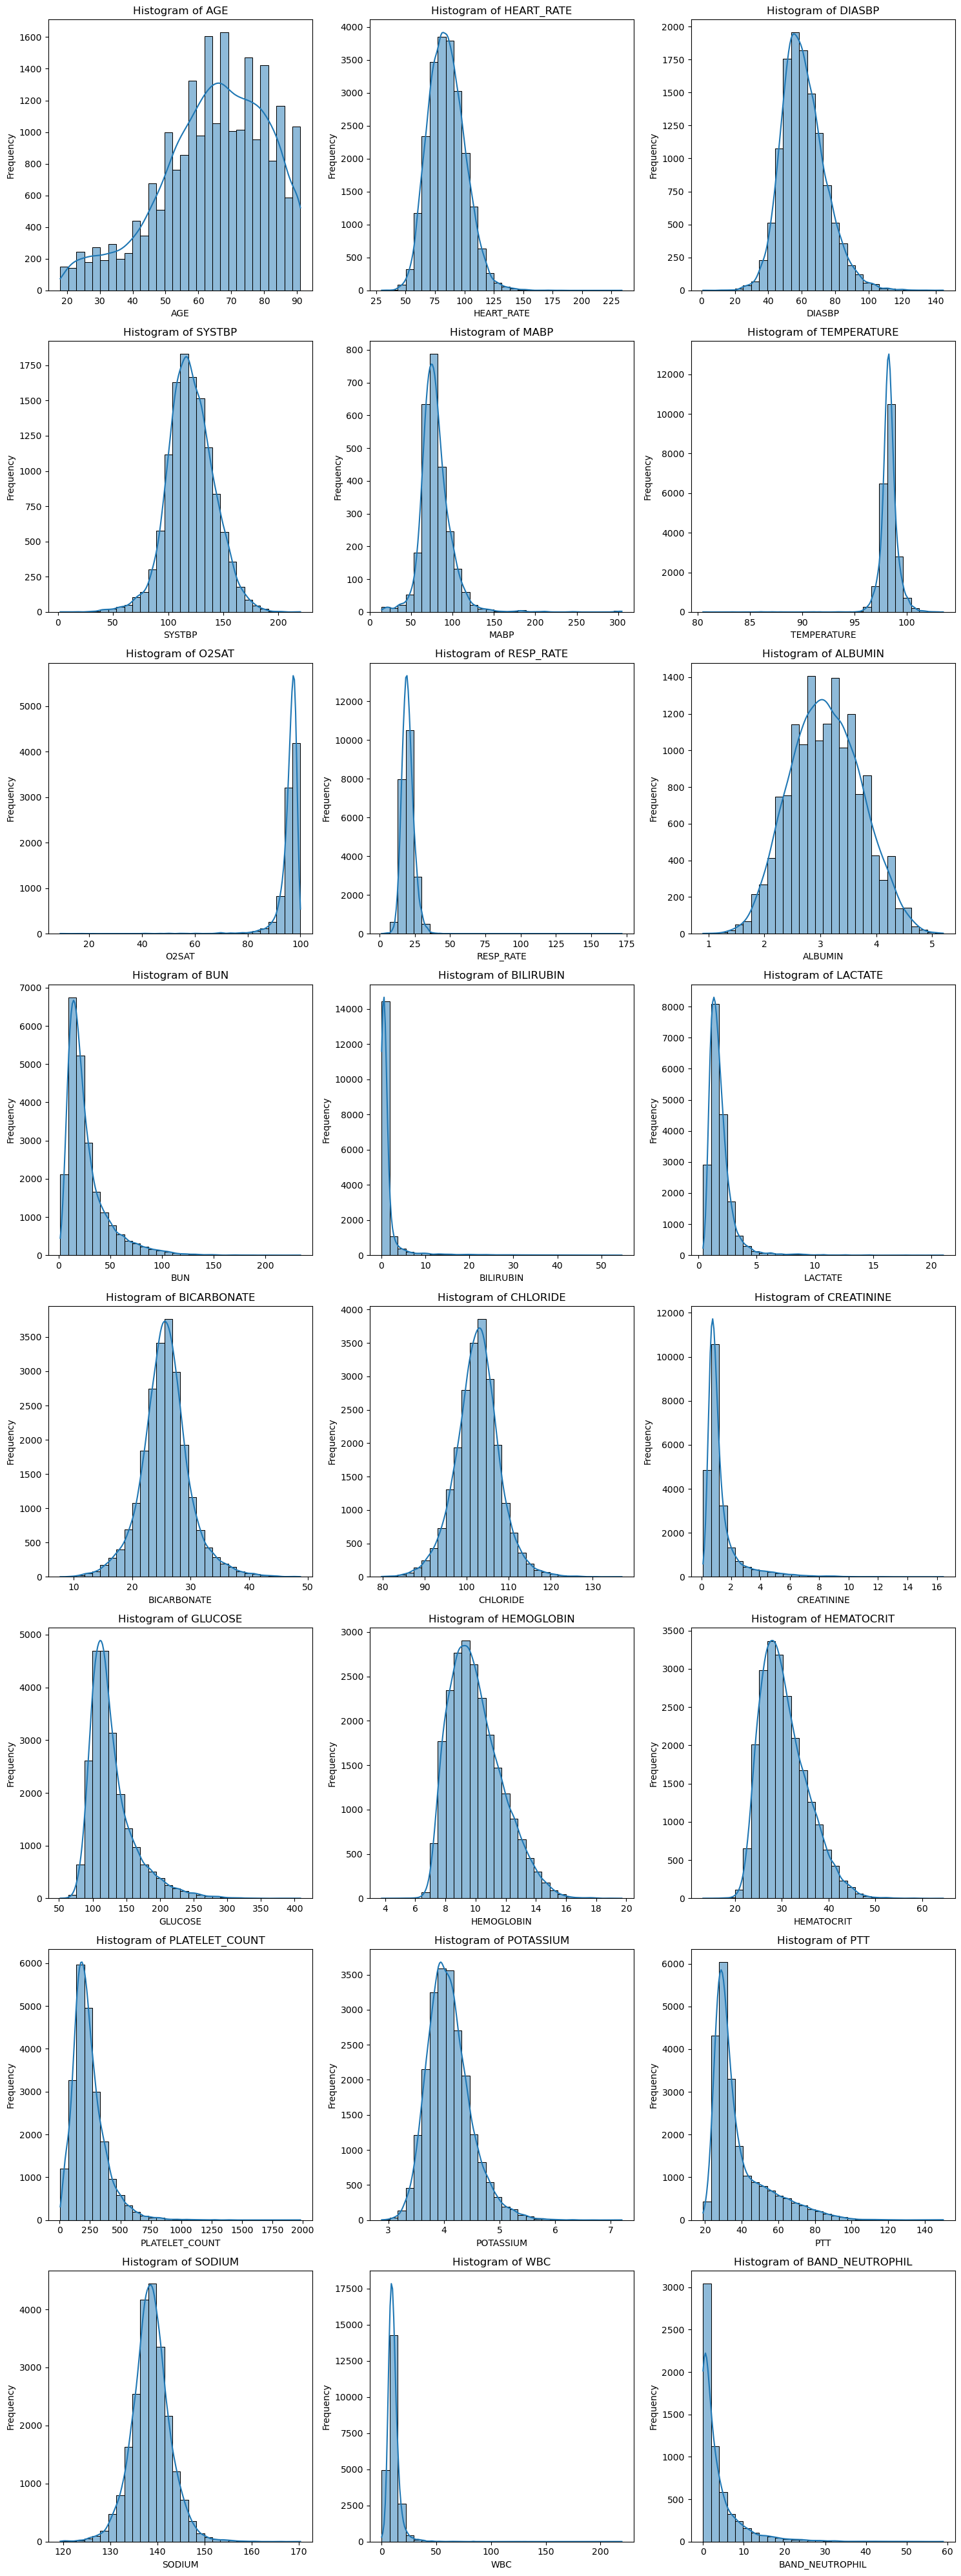

In [18]:
# Define the number of columns for the plot
num_columns = 3

# Calculate the number of rows needed
num_rows = int(np.ceil(len(num_cols) / num_columns))

# Create a figure and a set of subplots
fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5))

# Flatten the axes array for easier indexing
axs = axs.flatten()

# Iterate over each numerical column to plot histograms
for idx, col in enumerate(num_cols):
    col_data = data[col]
    
    # Plot histogram
    sns.histplot(col_data, kde=True, bins=30, ax=axs[idx])
    axs[idx].set_title(f'Histogram of {col}')
    axs[idx].set_xlabel(col)
    axs[idx].set_ylabel('Frequency')

# Remove any empty subplots
for idx in range(len(num_cols), len(axs)):
    fig.delaxes(axs[idx])

plt.tight_layout()
plt.show()

## Handling Missing Values

According to the MIMIC-IV documentation, the type of missingness in the dataset is most likely MAR (Missing at Random) and MNAR (Missing Not at Random). MAR could be caused by certain patient demographics or clinical conditions leading to fewer recorded measurements due to specific clinical practices or priorities. Data could be missing because of the severity of a patient's condition (MNAR).

### HEART_RATE

In [19]:
missing_values_heart_rate0 = data0['HEART_RATE'].isnull().sum()
print(f"Number of missing values in HEART_RATE for Class 0: {missing_values_heart_rate0}")
missing_values_heart_rate1 = data1['HEART_RATE'].isnull().sum()
print(f"Number of missing values in HEART_RATE for Class 1: {missing_values_heart_rate1}")

Number of missing values in HEART_RATE for Class 0: 1
Number of missing values in HEART_RATE for Class 1: 0


The distribution of 'HEART_RATE' is approximately normal, so I am going to replace the missing value with the mean value of heart rate from patients from Class 0.

In [20]:
# Calculate the mean of HEART_RATE from data0
mean_heart_rate = data0['HEART_RATE'].mean()
print(f"Mean HEART_RATE from data0: {mean_heart_rate}")

# Replace missing values in HEART_RATE of data with the mean from data0
data['HEART_RATE'].fillna(mean_heart_rate, inplace=True)

# Verify the replacement
missing_values_heart_rate_after = data['HEART_RATE'].isnull().sum()
print(f"Number of missing values in HEART_RATE after replacement: {missing_values_heart_rate_after}")

Mean HEART_RATE from data0: 83.74654869370609
Number of missing values in HEART_RATE after replacement: 0


### DIASBP and SYSTBP

The distribution of 'DIASBP' is right skewed. Within class 0, the percentage of missing values in DIASBP is 46.65%. Within class 1, the percentage of missing values in DIASBP is 38.67%.

The distribution of 'SYSTBP' is approximately normal. Within class 0, the percentage of missing values in SYSTBP is 46.68%. Within class 1, the percentage of missing values in SYSTBP is 38.70%.

Originally I was trying to replace the missing values in both of these features with the median from the respective classes. However when I did that in the earlier version of the EDA (not shown) in this notebook, it significantly alters the shape and distribution of both variables (as indicated by KL's divergence score before vs. after). 

Another thing that I observe that by doing median imputation for these two features, I inflated the strength of the relationship between the two features.

Also notice the distribution of missing values for each class are significantly different from class 0 vs. class 1 for both features. This is a good indication that the data are most likely not missing at random. The percentage of missingness for each class between the two features are also identical, meaning most likely if a patient has no systolic blood pressure measured, then most likely s/he also will not have the diastolic blood pressure measurement.

Considering the arguments above, I decide to just drop the two features.


In [21]:
missing_values_DIASBP0 = data0['DIASBP'].isnull().sum()
print(f"Number of missing values in DIASBP for Class 0: {missing_values_DIASBP0}")
missing_values_DIASBP1 = data1['DIASBP'].isnull().sum()
print(f"Number of missing values in DIASBP for Class 1: {missing_values_DIASBP1}")

Number of missing values in DIASBP for Class 0: 8997
Number of missing values in DIASBP for Class 1: 1268


In [22]:
missing_values_SYSTBP0 = data0['SYSTBP'].isnull().sum()
print(f"Number of missing values in SYSTBP for Class 0: {missing_values_SYSTBP0}")
missing_values_SYSTBP1 = data1['SYSTBP'].isnull().sum()
print(f"Number of missing values in SYSTBP for Class 1: {missing_values_SYSTBP1}")

Number of missing values in SYSTBP for Class 0: 9003
Number of missing values in SYSTBP for Class 1: 1269


In [23]:
data = data.drop(columns=['DIASBP', 'SYSTBP'])

### MABP and O2SAT

- There are 88% missing values for 'MABP' (89.41% within class 0 and 80.36% within class 1).
- There are 61% missing values for 'O2SAT' (63.42% within class 0 and 48.34% within class 1).

The percentage of missing values is too high, therefore we will drop these columns.

In [24]:
data = data.drop(columns=['MABP', 'O2SAT'])

### BAND_NEUTROPHIL

There are 73.84% missing values in total (77.49% within class 0 and 52.36% within class 1).
The percentage of missing values is too high, therefore we will drop this columns.

In [25]:
data = data.drop(columns=['BAND_NEUTROPHIL'])

### TEMPERATURE

The distribution for TEMPERATURE is right skewed. We will replace the missing values with the median.
There are 0.42% of missing values from the total observations.

In [26]:
# Calculate the median of TEMPERATURE from data0
median_temperature = data0['TEMPERATURE'].median()
print(f"Median TEMPERATURE from data0: {median_temperature}")

# Replace missing TEMPERATURE values in data where HOSPITAL_EXPIRE_FLAG is 0
condition = (data['HOSPITAL_EXPIRE_FLAG'] == 0) & (data['TEMPERATURE'].isnull())
data.loc[condition, 'TEMPERATURE'] = median_temperature

# Calculate the median of TEMPERATURE from data1
median_temperature = data1['TEMPERATURE'].median()
print(f"Median TEMPERATURE from data1: {median_temperature}")

# Replace missing TEMPERATURE values in data where HOSPITAL_EXPIRE_FLAG is 1
condition = (data['HOSPITAL_EXPIRE_FLAG'] == 1) & (data['TEMPERATURE'].isnull())
data.loc[condition, 'TEMPERATURE'] = median_temperature

Median TEMPERATURE from data0: 98.3
Median TEMPERATURE from data1: 98.2625


### RESP_RATE

The distribution for RESP_RATE is right skewed. We will replace the missing values with the median. There is only 1 missing value observation from class 0.

In [27]:
median_RESP_RATE = data0['RESP_RATE'].median()
print(f"Median RESP_RATE from data0: {median_RESP_RATE}")

condition = (data['HOSPITAL_EXPIRE_FLAG'] == 0) & (data['RESP_RATE'].isnull())
data.loc[condition, 'RESP_RATE'] = median_RESP_RATE


Median RESP_RATE from data0: 19.625


### ALBUMIN

The distribution for ALBUMIN is approximately normal. We will replace the missing values with the median. There are total of 33.29% of missing values. Within class 0, % missing is 35.77%. Within class 1, % missing is 18.69%.

In [28]:
# Calculate the median of ALBUMIN from data0
median_albumin = data0['ALBUMIN'].median()
print(f"Median ALBUMIN from data0: {median_albumin}")

# Replace missing ALBUMIN values in data where HOSPITAL_EXPIRE_FLAG is 0
condition = (data['HOSPITAL_EXPIRE_FLAG'] == 0) & (data['ALBUMIN'].isnull())
data.loc[condition, 'ALBUMIN'] = median_albumin

# Calculate the median of ALBUMIN from data1
median_albumin = data1['ALBUMIN'].median()
print(f"Median ALBUMIN from data1: {median_albumin}")

# Replace missing ALBUMIN values in data where HOSPITAL_EXPIRE_FLAG is 1
condition = (data['HOSPITAL_EXPIRE_FLAG'] == 1) & (data['ALBUMIN'].isnull())
data.loc[condition, 'ALBUMIN'] = median_albumin

Median ALBUMIN from data0: 3.15
Median ALBUMIN from data1: 2.7875


### BILIRUBIN

The distribution for BILIRUBIN is right skewed. We will replace the missing values with the median. There are total of 25.65% of missing values. Within class 0, % missing is 28.20%. Within class 1, % missing is 10.64%.

In [29]:

# Calculate the median of BILIRUBIN from data0
median_bilirubin = data0['BILIRUBIN'].median()
print(f"Median BILIRUBIN from data0: {median_bilirubin}")

# Replace missing BILIRUBIN values in data where HOSPITAL_EXPIRE_FLAG is 0
condition = (data['HOSPITAL_EXPIRE_FLAG'] == 0) & (data['BILIRUBIN'].isnull())
data.loc[condition, 'BILIRUBIN'] = median_bilirubin

# Calculate the median of BILIRUBIN from data1
median_bilirubin = data1['BILIRUBIN'].median()
print(f"Median BILIRUBIN from data1: {median_bilirubin}")

# Replace missing BILIRUBIN values in data where HOSPITAL_EXPIRE_FLAG is 1
condition = (data['HOSPITAL_EXPIRE_FLAG'] == 1) & (data['BILIRUBIN'].isnull())
data.loc[condition, 'BILIRUBIN'] = median_bilirubin

Median BILIRUBIN from data0: 0.6
Median BILIRUBIN from data1: 0.9


### LACTATE

The distribution for LACTATE is right skewed. We will replace the missing values with the median. There are total of 17.36% of missing values. Within class 0, % missing is 19.43%. Within class 1, % missing is 5.18%.

In [30]:
# Calculate the median of LACTATE from data0
median_lactate = data0['LACTATE'].median()
print(f"Median LACTATE from data0: {median_lactate}")

# Replace missing LACTATE values in data where HOSPITAL_EXPIRE_FLAG is 0
condition = (data['HOSPITAL_EXPIRE_FLAG'] == 0) & (data['LACTATE'].isnull())
data.loc[condition, 'LACTATE'] = median_lactate

# Calculate the median of LACTATE from data1
median_lactate = data1['LACTATE'].median()
print(f"Median LACTATE from data1: {median_lactate}")

# Replace missing LACTATE values in data where HOSPITAL_EXPIRE_FLAG is 1
condition = (data['HOSPITAL_EXPIRE_FLAG'] == 1) & (data['LACTATE'].isnull())
data.loc[condition, 'LACTATE'] = median_lactate

Median LACTATE from data0: 1.55
Median LACTATE from data1: 2.0


### CREATININE

The distribution for CREATININE is right skewed. We will replace the missing values with the median. There are total of 0.02% of missing values.

In [31]:
# Calculate the median of CREATININE from data0
median_creatinine = data0['CREATININE'].median()
print(f"Median CREATININE from data0: {median_creatinine}")

# Replace missing CREATININE values in data where HOSPITAL_EXPIRE_FLAG is 0
condition = (data['HOSPITAL_EXPIRE_FLAG'] == 0) & (data['CREATININE'].isnull())
data.loc[condition, 'CREATININE'] = median_creatinine

# Calculate the median of CREATININE from data1
median_creatinine = data1['CREATININE'].median()
print(f"Median CREATININE from data1: {median_creatinine}")

# Replace missing CREATININE values in data where HOSPITAL_EXPIRE_FLAG is 1
condition = (data['HOSPITAL_EXPIRE_FLAG'] == 1) & (data['CREATININE'].isnull())
data.loc[condition, 'CREATININE'] = median_creatinine

Median CREATININE from data0: 0.875
Median CREATININE from data1: 1.375


### PLATELET_COUNT

The distribution for PLATELET_COUNT is right skewed. We will replace the missing values with the median. There is only 1 missing value from class 0.

In [32]:
median_PLATELET_COUNT = data0['PLATELET_COUNT'].median()
print(f"Median PLATELET_COUNT from data0: {median_PLATELET_COUNT}")

condition = (data['HOSPITAL_EXPIRE_FLAG'] == 0) & (data['PLATELET_COUNT'].isnull())
data.loc[condition, 'PLATELET_COUNT'] = median_PLATELET_COUNT


Median PLATELET_COUNT from data0: 219.0


### PTT

The distribution for PTT is right skewed. We will replace the missing values with the median. There are total of 2.89% of missing values.

In [33]:
# Calculate the median of PTT from data0
median_ptt = data0['PTT'].median()
print(f"Median PTT from data0: {median_ptt}")

# Replace missing PTT values in data where HOSPITAL_EXPIRE_FLAG is 0
condition = (data['HOSPITAL_EXPIRE_FLAG'] == 0) & (data['PTT'].isnull())
data.loc[condition, 'PTT'] = median_ptt

# Calculate the median of PTT from data1
median_ptt = data1['PTT'].median()
print(f"Median PTT from data1: {median_ptt}")

# Replace missing PTT values in data where HOSPITAL_EXPIRE_FLAG is 1
condition = (data['HOSPITAL_EXPIRE_FLAG'] == 1) & (data['PTT'].isnull())
data.loc[condition, 'PTT'] = median_ptt

Median PTT from data0: 31.6
Median PTT from data1: 38.75


In [34]:
### Making sure there is no more missing values

data.isnull().sum()

AGE                     0
GENDER                  0
ETHNICITY               0
HEART_RATE              0
TEMPERATURE             0
RESP_RATE               0
ALBUMIN                 0
BUN                     0
BILIRUBIN               0
LACTATE                 0
BICARBONATE             0
CHLORIDE                0
CREATININE              0
GLUCOSE                 0
HEMOGLOBIN              0
HEMATOCRIT              0
PLATELET_COUNT          0
POTASSIUM               0
PTT                     0
SODIUM                  0
WBC                     0
HOSPITAL_EXPIRE_FLAG    0
dtype: int64

### Rechecking KL Divergence

After dealing with missing values I will once again recalculate the KL divergence to make sure the distribution is not significantly altered.

In [35]:
cols = list(data.columns)
num_cols = ['AGE','HEART_RATE','TEMPERATURE', 'RESP_RATE', 'ALBUMIN', 'BUN', 'BILIRUBIN', 'LACTATE', 'BICARBONATE', 'CHLORIDE', 'CREATININE', 'GLUCOSE', 'HEMOGLOBIN', 'HEMATOCRIT', 'PLATELET_COUNT', 'POTASSIUM', 'PTT', 'SODIUM', 'WBC', 'HOSPITAL_EXPIRE_FLAG']

In [36]:
# Store the results
kl_divergence_results = []

# Function to calculate KL divergence
def kl_divergence(p, q):
    return entropy(p, q)

# Iterate over each numerical column
for col in num_cols:
    col_data = data[col]
    
    # Calculate the probability distributions
    hist, bin_edges = np.histogram(col_data.dropna(), bins=30, density=True)
    
    # Assume normal distribution as reference distribution
    reference_distribution = norm.pdf(bin_edges[:-1], np.mean(col_data.dropna()), np.std(col_data.dropna()))
    
    # Normalize the histogram to make it a valid probability distribution
    hist /= np.sum(hist)
    reference_distribution /= np.sum(reference_distribution)
    
    # Calculate KL divergence
    kl_div = kl_divergence(hist, reference_distribution)
    kl_divergence_results.append({'Feature': col, 'KL Divergence': kl_div})

# Convert results to DataFrame
kl_divergence_df = pd.DataFrame(kl_divergence_results)

# Display KL divergence results
print(kl_divergence_df)

                 Feature  KL Divergence
0                    AGE       0.065410
1             HEART_RATE       0.040935
2            TEMPERATURE       0.294249
3              RESP_RATE       0.256393
4                ALBUMIN       0.263427
5                    BUN       0.300652
6              BILIRUBIN       1.260128
7                LACTATE       0.474169
8            BICARBONATE       0.053181
9               CHLORIDE       0.035973
10            CREATININE       0.531361
11               GLUCOSE       0.225293
12            HEMOGLOBIN       0.073793
13            HEMATOCRIT       0.080001
14        PLATELET_COUNT       0.156951
15             POTASSIUM       0.060117
16                   PTT       0.373272
17                SODIUM       0.048403
18                   WBC       0.471390
19  HOSPITAL_EXPIRE_FLAG       2.927277


### Bivariate Analysis

In [37]:
num_cols_no_target = ['AGE','HEART_RATE','TEMPERATURE', 'RESP_RATE', 'ALBUMIN', 'BUN', 'BILIRUBIN', 'LACTATE', 'BICARBONATE', 'CHLORIDE', 'CREATININE', 'GLUCOSE', 'HEMOGLOBIN', 'HEMATOCRIT', 'PLATELET_COUNT', 'POTASSIUM', 'PTT', 'SODIUM', 'WBC']

<Figure size 1300x1000 with 0 Axes>

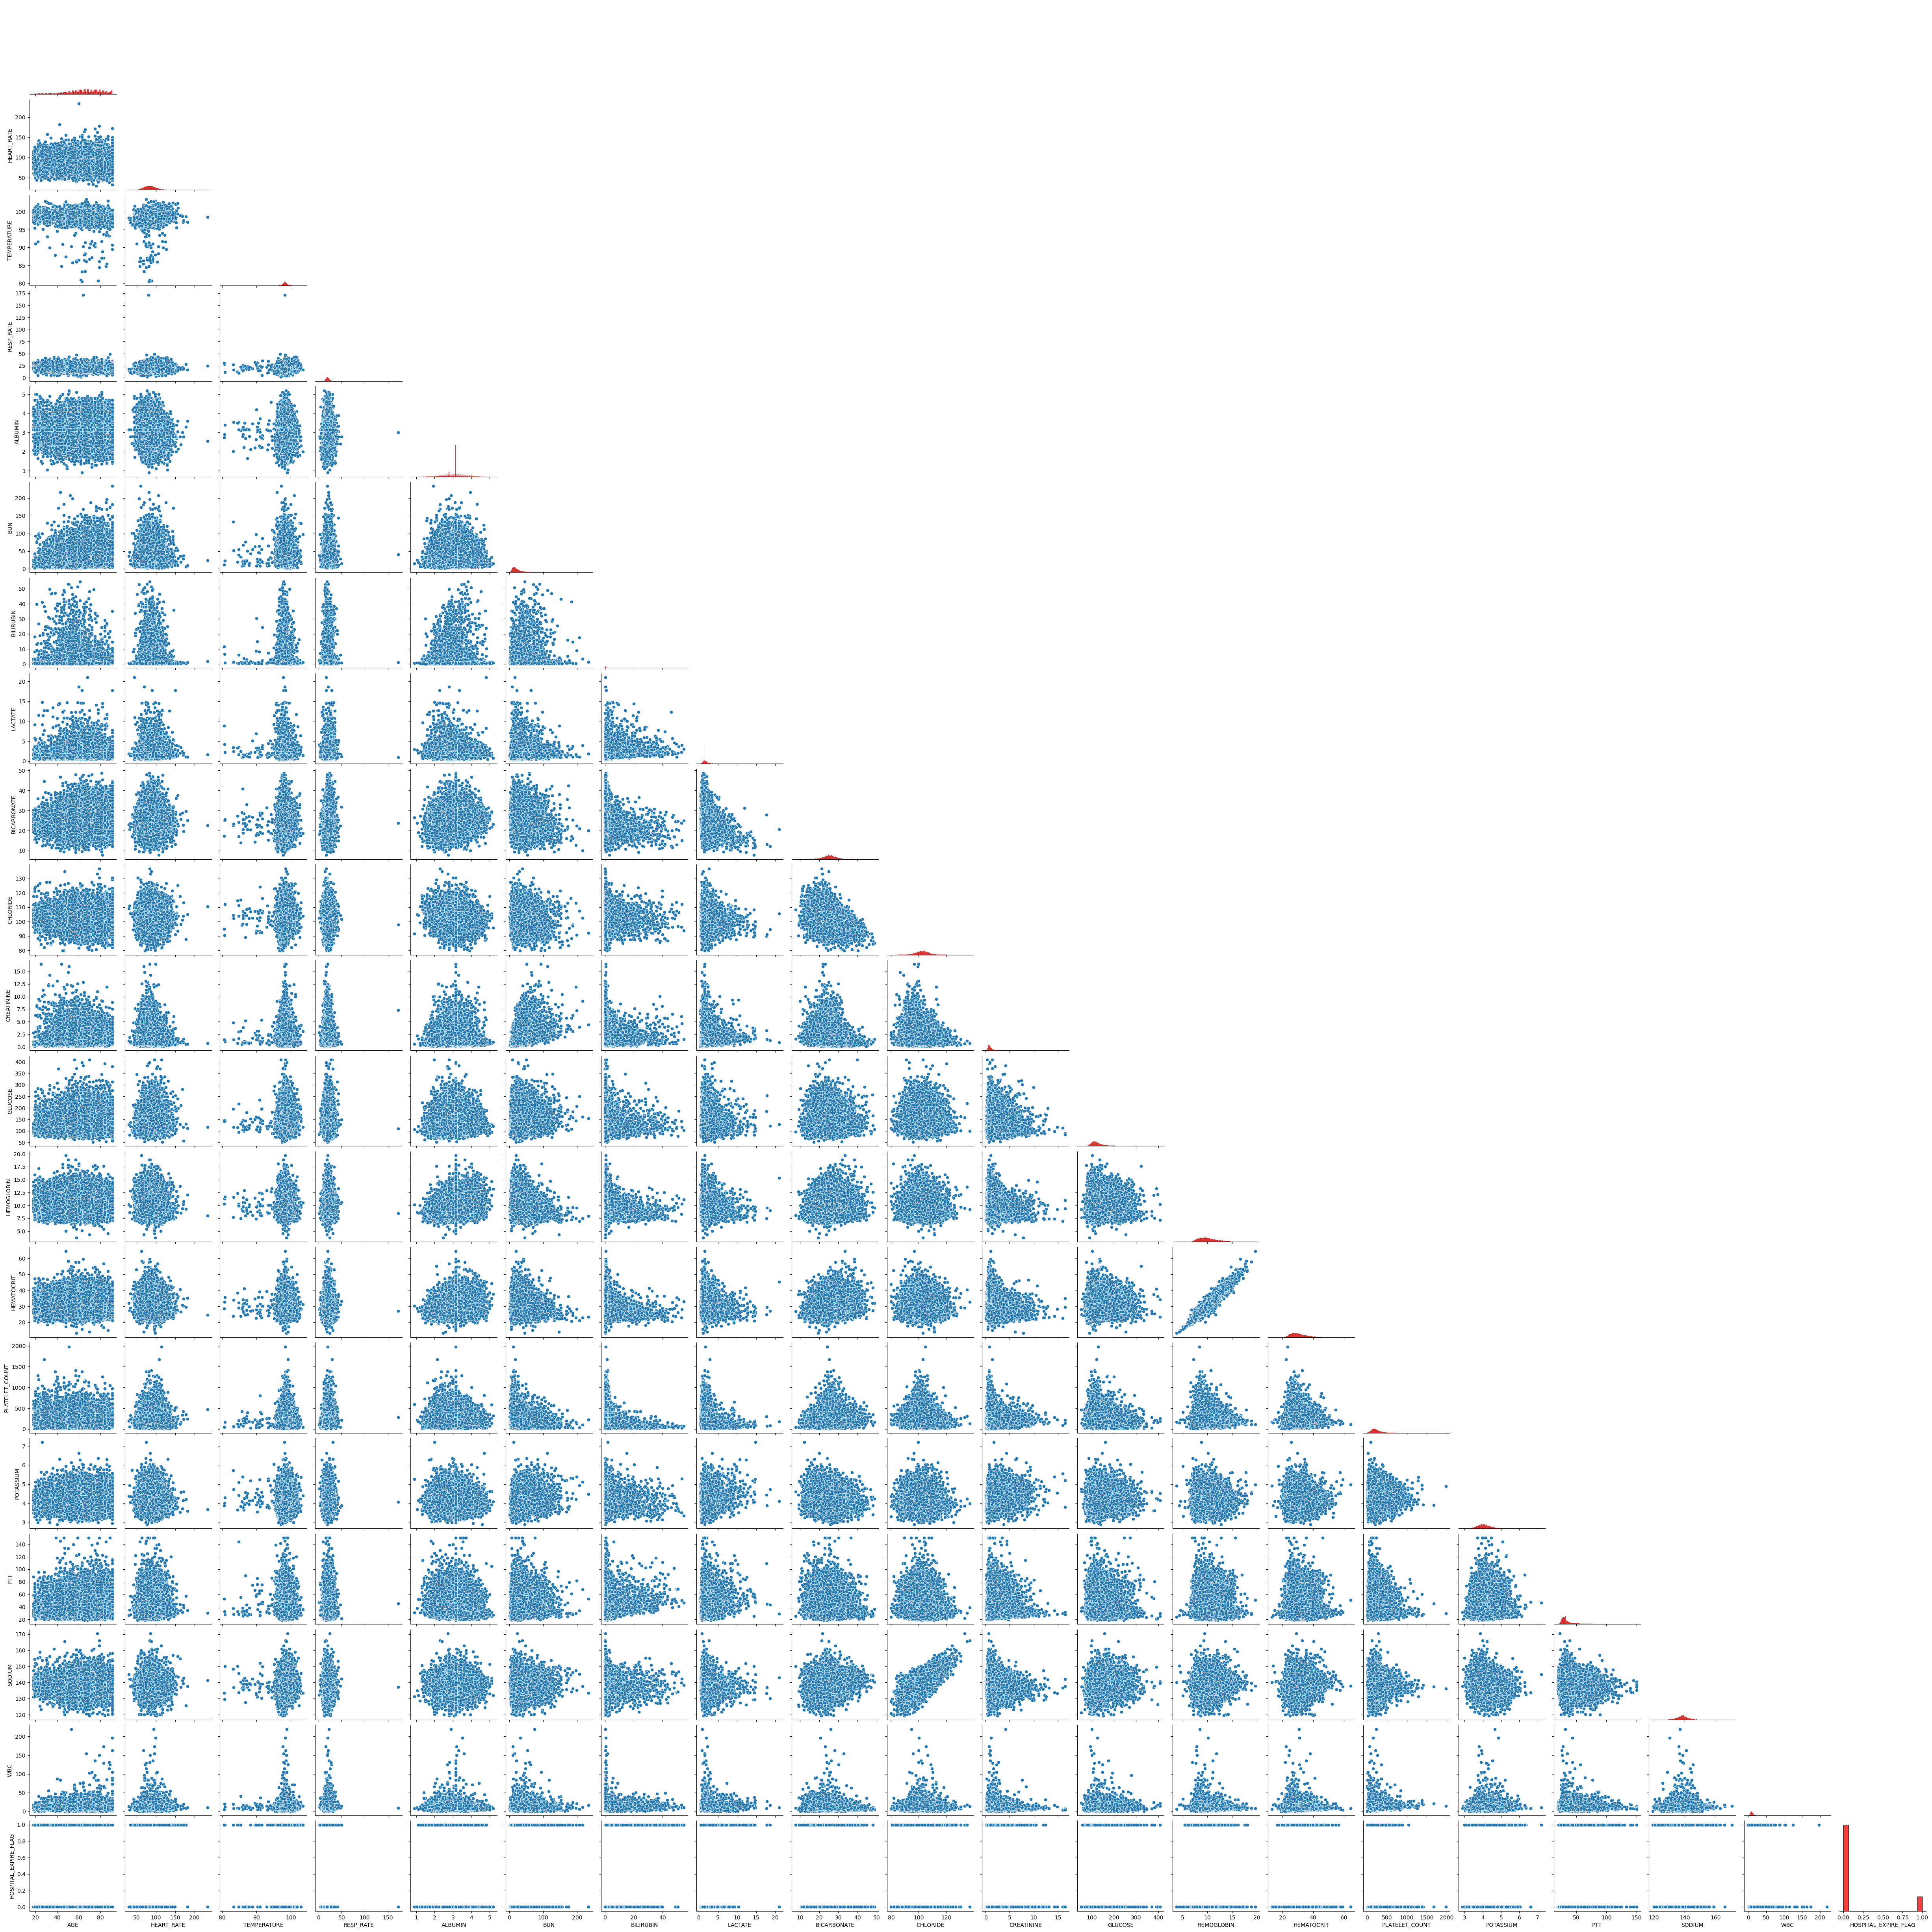

In [38]:
plt.figure(figsize=(13, 10))

sns.pairplot(data[num_cols], 
             diag_kind='hist', corner=True, diag_kws={'color': 'red'})

plt.yticks(rotation=0)
plt.show()

C:\Users\andre\AppData\Local\Temp\ipykernel_20324\1926582375.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr() # correlation


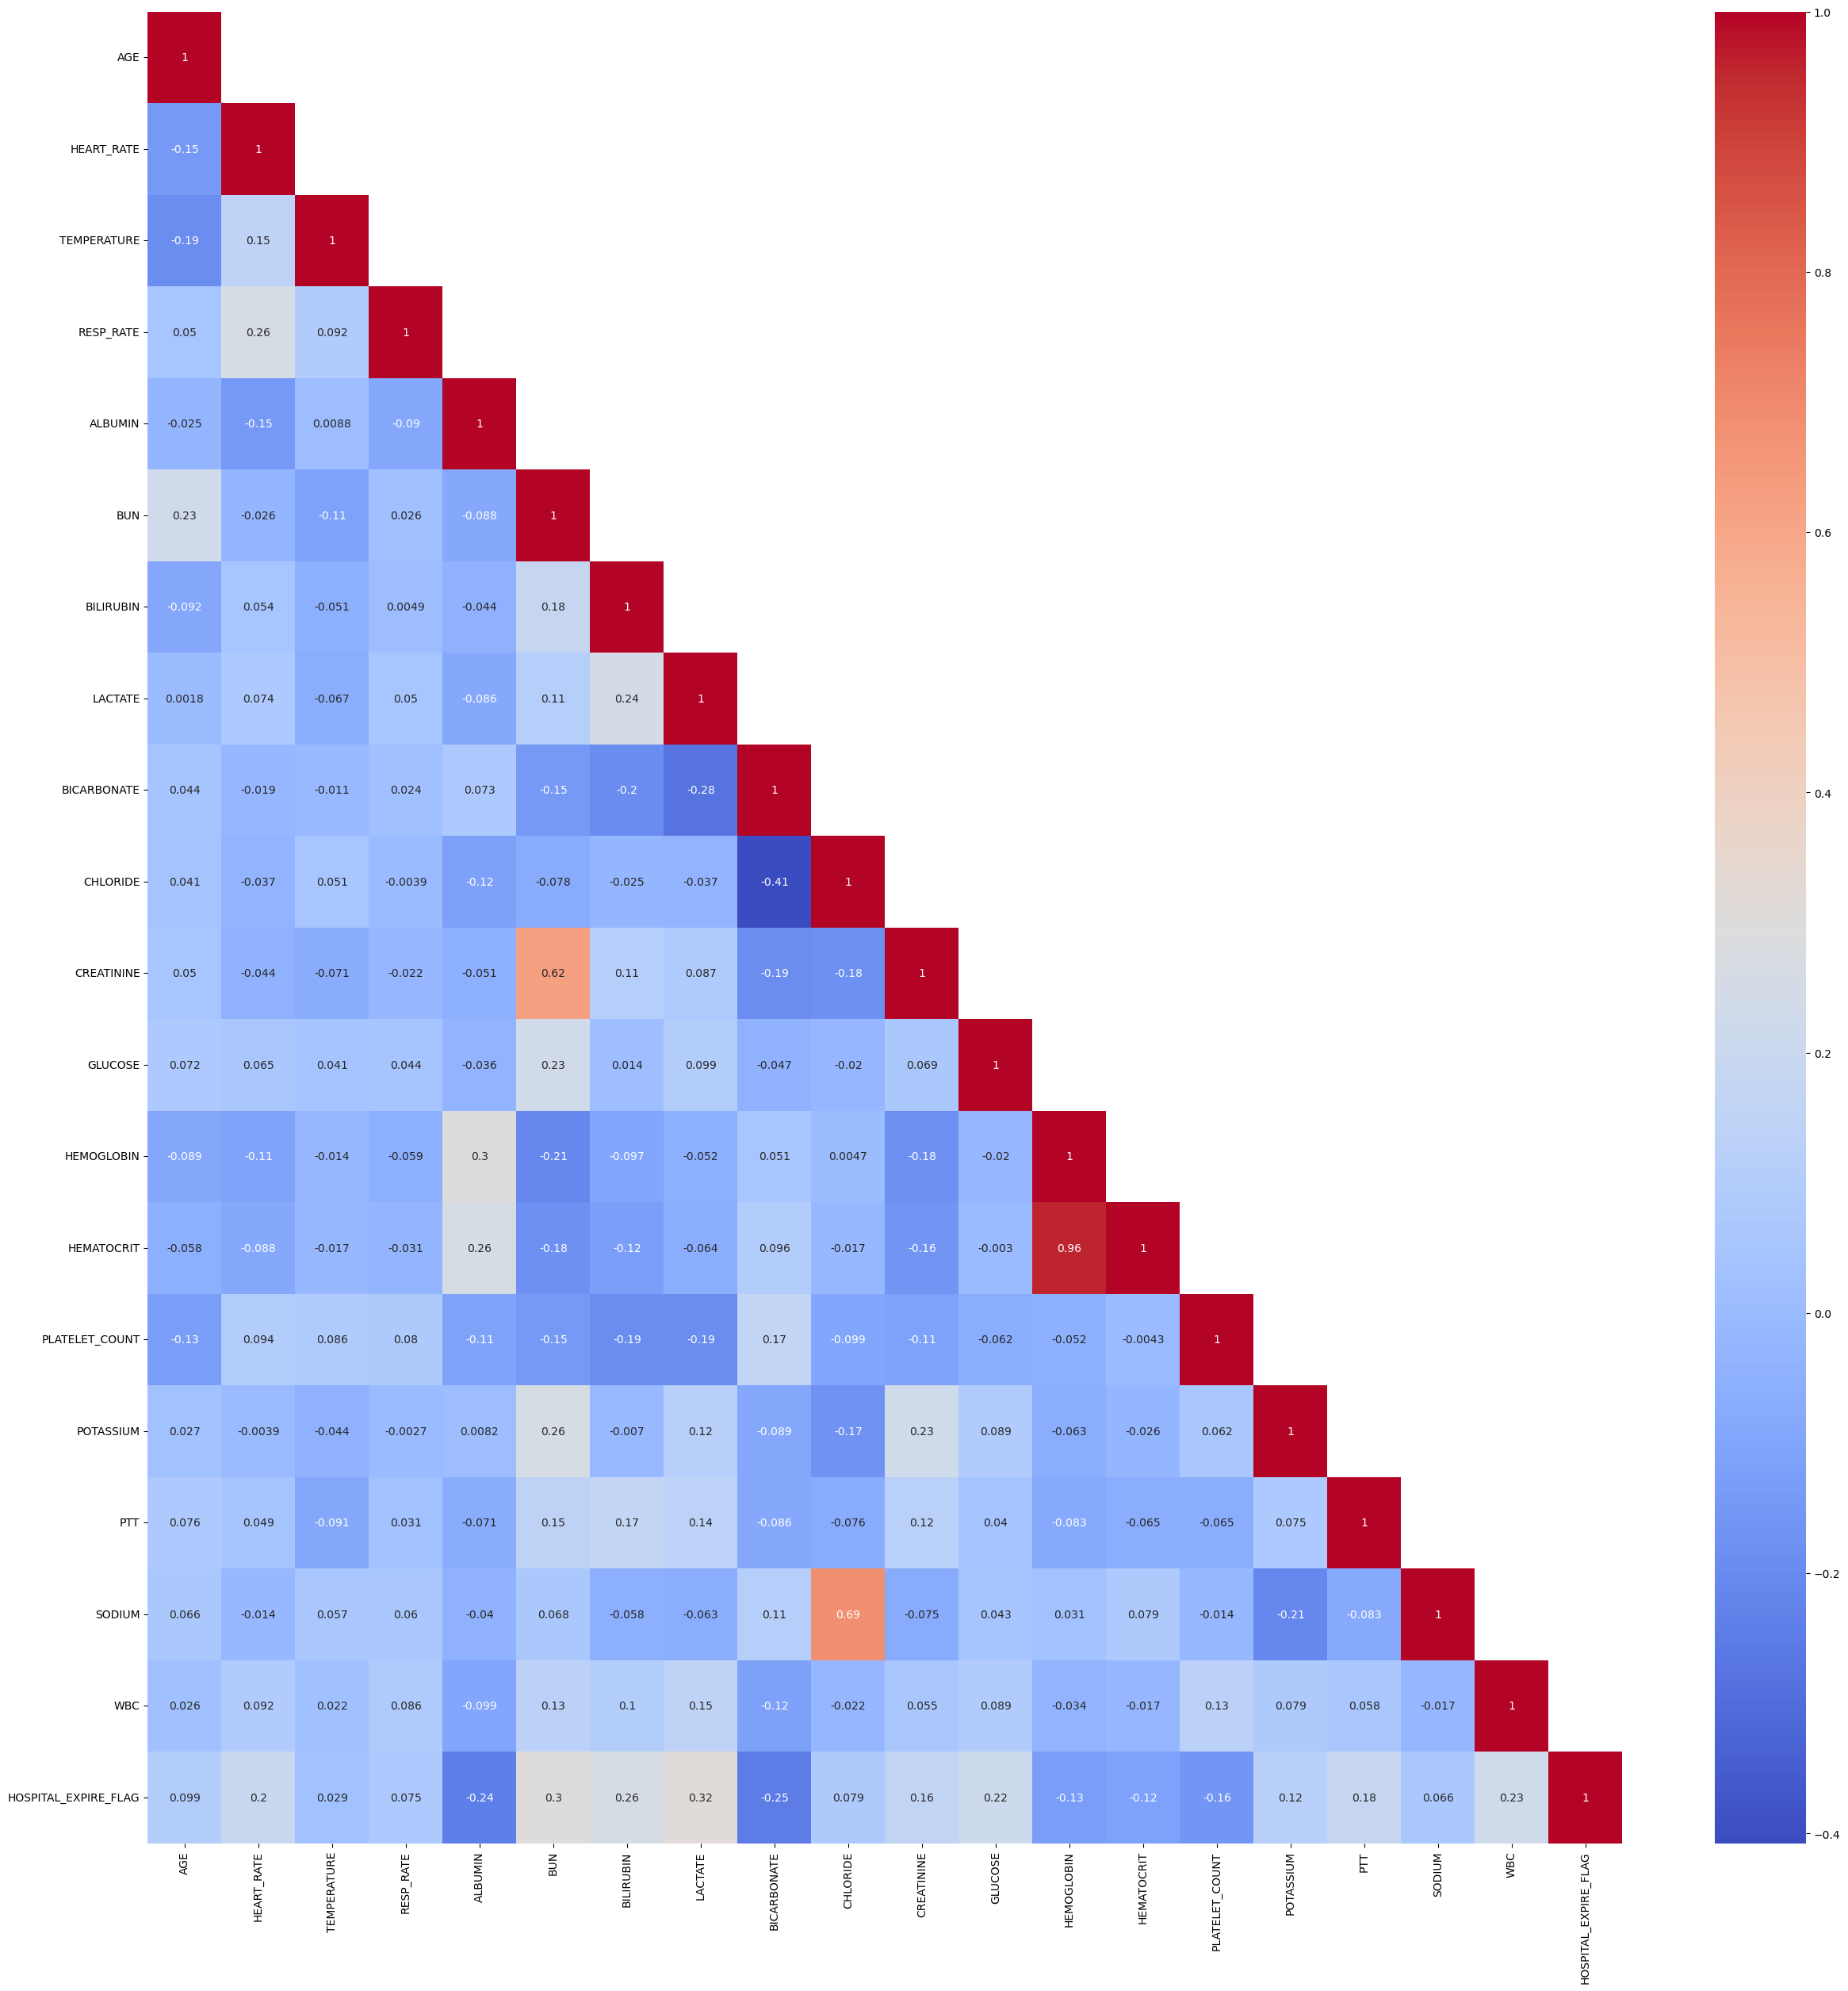

In [39]:
plt.figure(figsize=(30, 30))

corr = data.corr() # correlation
mask = np.triu(np.ones_like(corr, dtype=bool)) # masking the upper triangle
np.fill_diagonal(mask, False) # diagonal 1s

# heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', mask=mask)

plt.yticks(rotation=0)
plt.show()

In [40]:
df_with_const = add_constant(data[num_cols_no_target])

vif = pd.DataFrame()
vif["feature"] = df_with_const.columns
vif["VIF"] = [variance_inflation_factor(df_with_const.values, i) for i in range(df_with_const.shape[1])]
3
vif

feature           VIF
0            const  14685.458965
1              AGE      1.207572
2       HEART_RATE      1.166075
3      TEMPERATURE      1.096312
4        RESP_RATE      1.106975
5          ALBUMIN      1.208824
6              BUN      2.131926
7        BILIRUBIN      1.209277
8          LACTATE      1.294945
9      BICARBONATE      2.748871
10        CHLORIDE      5.180620
11      CREATININE      1.900004
12         GLUCOSE      1.098345
13      HEMOGLOBIN     16.071140
14      HEMATOCRIT     15.795112
15  PLATELET_COUNT      1.239323
16       POTASSIUM      1.215595
17             PTT      1.082323
18          SODIUM      4.122088
19             WBC      1.110443

- There is strong linear positive correlation between 'HEMOGLOBIN' and 'HEMATOCRIT'.
- There are moderate linear positive correlation between 'CREATININE' and 'BUN', 'SODIUM' and 'CHLORIDE'.
- There is moderate linear negative correlation between 'CHLORIDE' and 'BICARBONATE'.
- The Variance Inflation Factor (VIF) indicates strong multicollinearity between 'HEMOGLOBIN' and 'HEMATOCRIT'.

## Identifying multidimensional outliers using Mahalanobis distance

In [41]:
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler

# Calculate the mean and covariance matrix on the scaled data
mean = np.mean(data[num_cols], axis=0)
cov = np.cov(data[num_cols], rowvar=False)
inv_covmat = np.linalg.inv(cov)

# Calculate Mahalanobis distance for each observation
def mahalanobis_distance(row, mean, inv_covmat):
    diff = row - mean
    return np.sqrt(np.dot(np.dot(diff, inv_covmat), diff.T))

data['mahalanobis'] = pd.DataFrame(data[num_cols], columns=num_cols).apply(lambda row: mahalanobis_distance(row, mean, inv_covmat), axis=1)

# Determine the threshold for the 99% confidence interval
threshold = chi2.ppf(0.99, len(num_cols))

# Identify outliers (note: using np.sqrt(threshold) for the distance)
outliers = data[data['mahalanobis'] > np.sqrt(threshold)]

# Print the outliers DataFrame
print("Outliers:")
print(outliers)

Outliers:
        AGE GENDER               ETHNICITY  HEART_RATE  TEMPERATURE  \
11     55.0      F                 UNKNOWN   93.750000    97.522917   
29     89.0      F                   WHITE   80.166667    98.250000   
36     44.0      F                 UNKNOWN   87.750000    97.887500   
38     60.0      M                   WHITE   85.357143    96.562500   
66     53.0      F                   WHITE   74.500000    98.112500   
...     ...    ...                     ...         ...          ...   
22515  83.0      F  BLACK/AFRICAN AMERICAN   45.375000    95.912500   
22533  65.0      F                 UNKNOWN  126.609375    96.287500   
22545  60.0      M                   WHITE   86.016667    99.800000   
22555  66.0      F                 UNKNOWN  106.750000    98.100000   
22564  76.0      M                   WHITE  108.125000    99.387500   

       RESP_RATE   ALBUMIN        BUN  BILIRUBIN    LACTATE  BICARBONATE  \
11     23.750000  3.666667  58.375000  35.600000   2.700000  

The Mahalanobis distance has identified 1993 observations that are considered multidimensional outliers.

## Converting cleaned data to csv

In [42]:
data.to_csv('cleaned_health.csv', index=False)